# Installation

In [ ]:
# Download and insall twint

%%capture
!git clone --depth=1 https://github.com/twintproject/twint.git
!cd /content/twint && pip3 install . -r requirements.txt
!pip install aiohttp==3.7.0
!pip install nest_asyncio

# Import relevant libraries

In [ ]:
# Import libraries

import twint

# To avoid "the event loop is already running" error message
import nest_asyncio
nest_asyncio.apply()

import pandas as pd

import re
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords             
import nltk
nltk.download('punkt')
from textblob import TextBlob

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Scrape data using Twint

In [ ]:
# Create a dictionary of each candidate with its search names
# Loop through the search names to twint and obtain tweet for each candidate
candidate_search = {"Peter Obi":"PeterObi OR \"peter obi\" OR \"PETEROBI\" OR \"peterobi\"",
"Bola Tinubu":"Jagaban OR Tinubu OR BolaTinubu","Atiku Abubakar":"ATIKU OR atiku OR ATIKUABUBAKAR"}

In [ ]:
def twintConfig(search_string):
    c = twint.Config()
    c.Search = search_string[1]
    c.Limit = 2000
    c.Lang = 'en'
    c.Pandas = True
    c.Pandas_au = True          
    c.Pandas_clean = True
    c.Since = '2022-01-01'
    c.Until = '2023-01-30'
    # Config for file storage
    c.Store_csv = True  # To save tweets in a CSV format
    c.Output = 'president.csv'
    twint.run.Search(c)

In [ ]:
# Run the twint through a function 
# with the candidate_search dictionary and concatenate the resulting dataframes
def Run_Twint(search_vals):
    
    # Set empty dataframe for join
    out_df = pd.DataFrame()
    
    for candidate in search_vals.items():
        print("running for search item: "+candidate[0]+"\n")
        print("Search string: "+candidate[1]+"\n")
        
        # Run Twint
        twintConfig(candidate)
        
        # Get dataframe from Twint output
        tweets_df = twint.storage.panda.Tweets_df
        
        # Join Dataframes and create 'Candidate' column
        tweets_df["Candidate"]= candidate[0]
        out_df = pd.concat([out_df,tweets_df])
        
    return out_df

In [ ]:
tweets_df = Run_Twint(candidate_search)

Streaming output truncated to the last 5000 lines.
1619820547679846400 2023-01-29 22:11:28 +0000 <urFavDesigner> Peter Obi is a propaganda cancelling force!
1619820533226557440 2023-01-29 22:11:24 +0000 <domejike> Dear OBIdients,  We must be very vigilant on the day of Election if we must deliver on our mandate on @PeterObi. In as much as I am not a fan of Bwala, we must take this message very seriously, all eyes must be on all presiding officers on that day.  https://t.co/buQvDIgMNV
1619820529791418374 2023-01-29 22:11:23 +0000 <danzeal247> If you think this current NASS and HoR is speaking for you OMO iyaba left patient is smarter than you.  Think again ..these guys are hyaenas, No soul 🙄
1619820522237497351 2023-01-29 22:11:21 +0000 <tyronteelarry> @siradoms @MissPearls I am obidient - bro look at this other angle , wat if Peter obi is part of dat deal , wat if atiku told him to run , also so to make de plan look real - cos if buhari looses tomorrow ,obi will vice atiku , it's was b

In [ ]:
tweets_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Candidate
0,1619847829173960706,1619779203452526592,1.675037e+12,2023-01-29 23:59:52,+0000,,@Charles91253085 @GRVlagos This guy is intelli...,en,[],[],...,,,,,"[{'screen_name': 'Charles91253085', 'name': 'C...",,,,,Peter Obi
1,1619847787943989249,1619819575935385601,1.675037e+12,2023-01-29 23:59:42,+0000,,@JonathanAmanda5 @PeterPsquare There is always...,en,[],[],...,,,,,"[{'screen_name': 'JonathanAmanda5', 'name': 'J...",,,,,Peter Obi
2,1619847755714932736,1619847755714932736,1.675037e+12,2023-01-29 23:59:34,+0000,,Did you know that Peter Obi lived with the cur...,en,[],[],...,,,,,[],,,,,Peter Obi
3,1619847724056342531,1619608134460538880,1.675037e+12,2023-01-29 23:59:27,+0000,,"@Ohiss_ @PeterObi He will, by God's Grace. But...",en,[],[],...,,,,,"[{'screen_name': 'Ohiss_', 'name': '𝕺𝖍𝖎𝖗𝖊𝖒𝖊𝖓 🦇...",,,,,Peter Obi
4,1619847718788276226,1619578700961558529,1.675037e+12,2023-01-29 23:59:26,+0000,,@Indigo51603150 @okesigo_ @solakafinta @PeterO...,en,[],[],...,,,,,"[{'screen_name': 'Indigo51603150', 'name': 'In...",,,,,Peter Obi


# Clean Data

In [ ]:
tweets_df.shape

(6034, 39)

In [ ]:
tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'Candidate'],
      dtype='object')

In [ ]:
# drop irrelevant columns
tweets_df = tweets_df[['date', 'tweet', 'language', 'username', 'Candidate']]

In [ ]:
tweets_df.head()

,date,tweet,language,username,Candidate
0,2023-01-29 23:59:52,@Charles91253085 @GRVlagos This guy is intelli...,en,timomayor2,Peter Obi
1,2023-01-29 23:59:42,@JonathanAmanda5 @PeterPsquare There is always...,en,iBenjackson,Peter Obi
2,2023-01-29 23:59:34,Did you know that Peter Obi lived with the cur...,en,UzomaPreciousF1,Peter Obi
3,2023-01-29 23:59:27,"@Ohiss_ @PeterObi He will, by God's Grace. But...",en,officialtostech,Peter Obi
4,2023-01-29 23:59:26,@Indigo51603150 @okesigo_ @solakafinta @PeterO...,en,sola_comfort,Peter Obi


In [ ]:
tweets_df['language'].unique()

array(['en', 'ht', 'in', 'lv', 'und', 'qme', 'tl', 'zxx', 'qam', 'pt',
       'pl', 'ca', 'es', 'art', 'eu', 'sv', 'fr', 'ro', 'da', 'is', 'de',
       'fi', 'it', 'lt', 'tr', 'et', 'cs', 'cy', 'hi', 'sl', 'nl', 'no',
       'hu'], dtype=object)

In [ ]:
# Remove all rows where language is not english or undefined
tweets_df = tweets_df[tweets_df['language'].isin([ 'und', 'en'])]

In [ ]:
# Removing tweets from candidate's account
tweets_df = tweets_df[ ~tweets_df['username'].str.lower().str.contains('atiku|tinubu|peterobi|po|bolatinubu', regex = True)]

In [ ]:
# Drop duplicated tweets 
tweets_df = tweets_df.drop_duplicates(subset=['date', "tweet", "Candidate"], keep = "first")

In [ ]:
len(tweets_df)

5102

In [ ]:
# Convert tweets to lowercase 
tweets_df['tweet'] = tweets_df['tweet'].str.lower()
tweets_df.head()

,date,tweet,language,username,Candidate
0,2023-01-29 23:59:52,@charles91253085 @grvlagos this guy is intelli...,en,timomayor2,Peter Obi
1,2023-01-29 23:59:42,@jonathanamanda5 @peterpsquare there is always...,en,iBenjackson,Peter Obi
2,2023-01-29 23:59:34,did you know that peter obi lived with the cur...,en,UzomaPreciousF1,Peter Obi
3,2023-01-29 23:59:27,"@ohiss_ @peterobi he will, by god's grace. but...",en,officialtostech,Peter Obi
4,2023-01-29 23:59:26,@indigo51603150 @okesigo_ @solakafinta @petero...,en,sola_comfort,Peter Obi


In [ ]:
# Removing punctuations and symbols
def clean_text(text):  
    pat1 = r'@[^ ]+'                   
    pat2 = r'https?://[A-Za-z0-9./]+'  
    pat3 = r'\'s'                      
    pat4 = r'\#\w+'                     
    pat5 = r'&amp '                     
    pat6 = r'[^A-Za-z\s]'               
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5, pat6))
    text = re.sub(combined_pat,"",text).lower()
    return text.strip()

In [ ]:
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(clean_text)

In [ ]:
tweets_df['cleaned_tweet'].head()

0    this guy is intelligent and smart wow lasgidi ...
1    there is always someone from your village read...
2    did you know that peter obi lived with the cur...
3    he will by god grace but if he doesnt well you...
4    you that you are opening your dirty mouthwhat ...
Name: cleaned_tweet, dtype: object

In [ ]:
# Save cleaned dataframe to CSV
tweets_df.to_csv('cleaned_presidential.csv')

In [ ]:
# Reset index 
tweets_df.reset_index(drop = True, inplace = True)

# Sentiment Analysis

In [ ]:
for row in tweets_df.itertuples():
    tweet = tweets_df.at[row[0], 'cleaned_tweet']

    #run sentiment using TextBlob
    analysis = TextBlob(tweet)

    #set value to dataframe
    tweets_df.at[row[0], 'polarity'] = analysis.sentiment[0]
    tweets_df.at[row[0], 'subjectivity'] = analysis.sentiment[1]

    #Create Positive / negative column depending on polarity
    if analysis.sentiment[0] >= 0.05:
        tweets_df.at[row[0], 'Sentiment'] = 'Positive'
    elif analysis.sentiment[0] <= -0.05:
        tweets_df.at[row[0], 'Sentiment'] = 'Negative'
    else:
        tweets_df.at[row[0], 'Sentiment'] = 'Neutral'

In [ ]:
tweets_df[['cleaned_tweet', 'polarity', 'Sentiment']].head()

,cleaned_tweet,polarity,Sentiment
0,this guy is intelligent and smart wow lasgidi ...,0.371429,Positive
1,there is always someone from your village read...,0.200000,Positive
2,did you know that peter obi lived with the cur...,0.000000,Neutral
3,he will by god grace but if he doesnt well you...,1.000000,Positive
4,you that you are opening your dirty mouthwhat ...,-0.600000,Negative


In [ ]:
tweets_df['Candidate'].unique()

array(['Peter Obi', 'Bola Tinubu', 'Atiku Abubakar'], dtype=object)

In [ ]:
tweets_df[tweets_df.Candidate == 'Atiku Abubakar'].groupby('Sentiment').count()

,date,tweet,language,username,Candidate,cleaned_tweet,polarity,subjectivity
Sentiment,,,,,,,,
Negative,209,209,209,209,209,209,209,209
Neutral,785,785,785,785,785,785,785,785
Positive,573,573,573,573,573,573,573,573


In [ ]:
tweets_df[tweets_df.Candidate == 'Bola Tinubu'].groupby('Sentiment').count()

,date,tweet,language,username,Candidate,cleaned_tweet,polarity,subjectivity
Sentiment,,,,,,,,
Negative,335,335,335,335,335,335,335,335
Neutral,775,775,775,775,775,775,775,775
Positive,613,613,613,613,613,613,613,613


In [ ]:
tweets_df[tweets_df.Candidate == 'Peter Obi'].groupby('Sentiment').count()

,date,tweet,language,username,Candidate,cleaned_tweet,polarity,subjectivity
Sentiment,,,,,,,,
Negative,272,272,272,272,272,272,272,272
Neutral,873,873,873,873,873,873,873,873
Positive,667,667,667,667,667,667,667,667


# Model Implementation

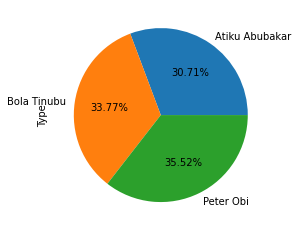

In [ ]:
# Data representation before sampling
tweets_df.groupby('Candidate').size().plot(kind='pie',
                                       y = 'v1',
                                       label = 'Type',
                                       autopct='%1.2f%%')

In [ ]:
data = tweets_df.drop(['Candidate'], axis = 1)
target = tweets_df['Candidate']

In [ ]:
def undersampling():
    print('Original dataset', sorted(Counter(target).items()))
    from imblearn.under_sampling import RandomUnderSampler
    ros = RandomUnderSampler(random_state = 42)
    xx, yy = ros.fit_resample(data, target)
    print('After undersampling', sorted(Counter(yy).items()))
    return xx, yy

In [ ]:
datax, targetx = undersampling()

Original dataset [('Atiku Abubakar', 1567), ('Bola Tinubu', 1723), ('Peter Obi', 1812)]
After undersampling [('Atiku Abubakar', 1567), ('Bola Tinubu', 1567), ('Peter Obi', 1567)]


In [ ]:
new_df = pd.concat([datax, targetx], axis = 1)

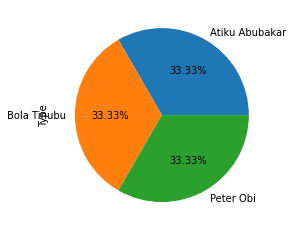

In [ ]:
# Data representation after sampling
new_df.groupby('Candidate').size().plot(kind='pie',
                                       y = 'v1',
                                       label = 'Type',
                                       autopct='%1.2f%%')

In [ ]:
# Label encoding
lb_encoder = preprocessing.LabelEncoder().fit(new_df['Candidate'])
new_df['encoded_win'] = lb_encoder.transform(new_df['Candidate']) 

In [ ]:
X = new_df[['polarity']]
y = new_df['encoded_win']

In [ ]:
new_df.tail()

,date,tweet,language,username,cleaned_tweet,polarity,subjectivity,Sentiment,Candidate,encoded_win
4696,2023-01-29 21:54:47,"@peterobi set up , igbo we understand una game...",en,Ife_wells,set up igbo we understand una games tinubu is...,0.000000,0.000000,Neutral,Peter Obi,2
4697,2023-01-29 21:41:33,see love everywhere. when the righteous rule t...,en,LabourPartyFr,see love everywhere when the righteous rule th...,0.300000,0.691667,Positive,Peter Obi,2
4698,2023-01-29 22:16:05,@samclaat @inecnigeria @_ikemba @aishayesufu @...,en,SunskySolar,the truth is that it not right but if you see ...,-0.142857,0.535714,Negative,Peter Obi,2
4699,2023-01-29 22:45:34,@ayoadegbites @odogwu_cc @peterobi the lady as...,en,lee_zamba,the lady asked a foolish question though,0.000000,0.000000,Neutral,Peter Obi,2
4700,2023-01-29 23:12:14,@bishoposama @simon_ekpa anonymous scammers ta...,en,Okechuk45055009,anonymous scammers talking all the followers...,0.000000,0.000000,Neutral,Peter Obi,2


In [ ]:
# Splitting dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.35494155154091395

In [ ]:
svm = svm.SVC(random_state = 42)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.3528161530286929

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.33581296493092455

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.33049946865037194

In [ ]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.3241232731137088

In [ ]:
mlp = MLPClassifier(random_state = 42)
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.3538788522848034

# Prediction

In [ ]:
prediction = mlp.predict(X_test)

In [ ]:
news = list(prediction)
atiku_count = news.count(0)
tinubu_count = news.count(1)
obi_count = news.count(2)

if obi_count > tinubu_count and obi_count > atiku_count:
    print("Peter Obi wins")
elif tinubu_count > obi_count and tinubu_count > atiku_count:
    print("Tinubu wins")
elif atiku_count > obi_count and atiku_count > tinubu_count:
    print("Atiku wins")
else:
    print("It's a tie")

Peter Obi wins
